In [1]:
from transformers import GPT2Model, GPT2Tokenizer
import pandas as pd
import numpy as np
import torch
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
def cosine_similarity(embeddings1, embeddings2):
    # Calculate cosine similarities for each corresponding layer's embeddings
    cosine_similarity = [1 - cosine(embedding1, embedding2) for embedding1, embedding2 in zip(embeddings1, embeddings2)]
    return cosine_similarity

In [3]:
def euclidean_distances(embeddings1, embeddings2):

    if len(embeddings1) != len(embeddings2):
        raise ValueError("Both embeddings lists should have the same number of layers.")

    # Calculate Euclidean distance for each layer
    euclidean_distances = [np.linalg.norm(embedding1 - embedding2) for embedding1, embedding2 in zip(embeddings1, embeddings2)]
    return euclidean_distances

In [4]:
def get_word_embeddings_without_subword(sentence, word1, word2, tokenizer, model):
    # Tokenize input text and convert to IDs
    inputs = tokenizer(sentence, return_tensors="pt")
    token_ids = inputs['input_ids'].squeeze().tolist()  # Convert tensor to list of token IDs
    tokens = tokenizer.convert_ids_to_tokens(token_ids)  # Convert token IDs to tokens

    # Find indices of tokens corresponding to the target words
    indices_word1 = [i for i, token in enumerate(tokens) if word1 in token]
    indices_word2 = [i for i, token in enumerate(tokens) if word2 in token]

    # Get model output
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of hidden states from each layer

    # Extract embeddings for each target word from each layer
    embeddings_word1 = [hidden_states[layer][0, idx].detach().numpy() for layer in range(len(hidden_states)) for idx in indices_word1]
    embeddings_word2 = [hidden_states[layer][0, idx].detach().numpy() for layer in range(len(hidden_states)) for idx in indices_word2]

    return embeddings_word1, embeddings_word2

In [14]:
def get_word_embeddings(sentence, word1, word2, tokenizer, model):
    # Tokenize input text and convert to IDs
    inputs = tokenizer(sentence, return_tensors="pt")
    token_ids = inputs['input_ids'].squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    # Prepare model and get output
    model_output = model(**inputs, output_hidden_states=True)
    hidden_states = model_output.hidden_states

    # Function to find and aggregate subword embeddings
    def aggregate_embeddings(word):
        # Include the 'Ġ' prefix for matching the start of words
        word_tokens = tokenizer.tokenize(' ' + word)  # Added space to ensure prefix
        indices = [i for i in range(len(tokens)) if tokens[i:i+len(word_tokens)] == word_tokens]

        # Flatten the list to capture all indices of subword tokens in range
        flattened_indices = [idx for i in indices for idx in range(i, i + len(word_tokens))]
        if not flattened_indices:
            return []
        # Average embeddings across subword tokens for each layer
        return [hidden_states[layer][0, flattened_indices].mean(dim=0).detach().numpy() 
                for layer in range(len(hidden_states))]

    embeddings_word1 = aggregate_embeddings(word1)
    embeddings_word2 = aggregate_embeddings(word2)

    return embeddings_word1, embeddings_word2

In [15]:
# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)

In [16]:
df = pd.read_csv("data/5000_synonym.csv", index_col = "rank")
df.head()

,lemma,PoS,freq,synonym,synset
rank,,,,,
26,say,v,4096416,tell,Synset('state.v.01')
31,go,v,3546732,belong,Synset('belong.v.03')
34,get,v,3347615,convey,Synset('bring.v.04')
39,know,v,2761628,NaN,NaN
49,would,v,2349400,NaN,NaN


In [21]:
# Example usage
pos = "nouns"
word1 = "leader"
word2 = "forerunner"
sentence = "What is the similarity between {0} {1} and {2}".format(pos, word1, word2)
embeddings_word1, embeddings_word2 = get_word_embeddings(sentence, word1, word2, tokenizer, model)

In [22]:
c = cosine_similarity(embeddings_word1, embeddings_word2)

Text(0, 0.5, 'Cosine Similarity')

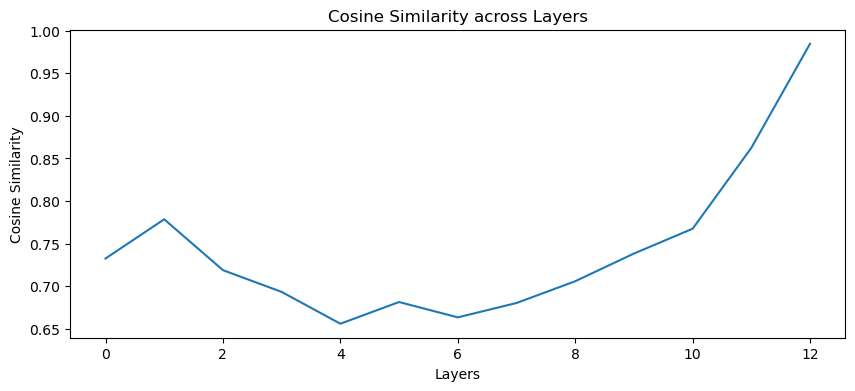

In [23]:
plt.figure(figsize=(10,4))
plt.title("Cosine Similarity across Layers")
plt.plot(c)
plt.xlabel("Layers")
plt.ylabel("Cosine Similarity")
# plt.ylim([0.5, 1.05])

In [24]:
c

[0.7325100898742676,
 0.7785689830780029,
 0.7188116312026978,
 0.6932660341262817,
 0.6558870077133179,
 0.6813659071922302,
 0.6633538007736206,
 0.6802184581756592,
 0.7057722806930542,
 0.7383016347885132,
 0.7674803137779236,
 0.8624678254127502,
 0.9847827553749084]